In [155]:
import os
import numpy as np
import pandas as pd
import torch as t
from torch import nn

# BehaviorNet in PyTorch

Using a simple LSTM network to learn activities representations (activity embedding analog to a word embedding in a language model).

In [156]:
device = t.device('cpu')

## Load and prepare the artifical logfiles

In [157]:
%%bash
ls -lisa ./Data

total 12752
8604106216    0 drwxr-xr-x   5 matthiasgroncki  staff      160 Nov  9 07:10 .
8604100559    0 drwxr-xr-x  14 matthiasgroncki  staff      448 Nov  9 08:53 ..
8604106313    8 -rw-r--r--   1 matthiasgroncki  staff      320 Nov  9 07:10 id2action.npy
8604126099 8544 -rw-r--r--   1 matthiasgroncki  staff  4373842 Nov  9 07:10 logfile_fraudulent_activities.pkl
8604106218 4200 -rw-r--r--   1 matthiasgroncki  staff  2147215 Nov  8 16:10 logfile_v1.pkl


In [158]:
logfile = pd.read_pickle('./Data/logfile_fraudulent_activities.pkl')

In [159]:
id2action = np.load('./Data/id2action.npy')
action2id = {a : i for i,a in enumerate(id2action)}

In [160]:
logfile['SessionActivityInt'] = logfile.SessionActivity.map(lambda ls: np.array([action2id[a] for a in ls]+[action2id['start']]))

In [161]:
logfile.head()

,UserID,Day,UserSessionId,SessionActivity,PotentialFraudster,FraudulentActivity,SessionActivityInt
0,0,0,0,"[start, action_1, action_2, action_2, end]",0,0,"[1, 3, 4, 4, 2, 1]"
1,0,0,0,"[start, action_2, end]",0,0,"[1, 4, 2, 1]"
2,0,0,0,"[start, action_1, action_1, action_2, end]",0,0,"[1, 3, 3, 4, 2, 1]"
3,0,0,0,"[start, action_3, action_2, end]",0,0,"[1, 5, 4, 2, 1]"
4,0,0,0,"[start, action_3, action_2, end]",0,0,"[1, 5, 4, 2, 1]"


## Network Design

In [162]:
class VerySimpleBehaviorNet(nn.Module):
    '''
    Very simple network consisting of an embedding layer, LSTM layers and a decoder with dropouts
    '''
    def __init__(self, n_actions=6, embedding_size=3, n_nodes=6, n_layers=2, dropout=0.2, 
                 padding_idx=0, initrange=0.5):
        super(VerySimpleBehaviorNet, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(n_actions, embedding_size, padding_idx)
        self.rnn = nn.LSTM(embedding_size, n_nodes, n_layers, dropout=dropout)
        self.decoder = nn.Linear(n_nodes, n_actions)
        self.init_weights(initrange)
        self.n_nodes = n_nodes
        self.n_layers = n_layers
        
    def init_weights(self, initrange=0.1):
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # Set the first row to zero (padding idx)
        self.embedding.weight.data[0,:] = 0
        print(self.embedding.weight)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (weight.new_zeros(self.n_layers, batch_size, self.n_nodes),
                weight.new_zeros(self.n_layers, batch_size, self.n_nodes))
    
    def forward(self, input, hidden):
        emb = self.dropout(self.embedding(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.dropout(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

In [163]:
def get_batch(i, batch_size, input):
    '''
    Takes a column/list of activity tensors of variable lenght
    and returns the padded i-th minibatch of batch_size activities 
    '''
    data = input[i*batch_size : (i+1) * batch_size]
    data = sorted(data, key=len, reverse=True)
    x = nn.utils.rnn.pad_sequence([x[:-1] for x in data])
    y = nn.utils.rnn.pad_sequence([y[1:] for y in data])
    return x, y

In [164]:
def split_train_test(input, device, prop=0.8, seed=42):
    np.random.seed(42)
    mask = np.random.uniform(size=input.shape[0])<=prop
    train = input[mask]
    test = input[~mask]
    train = [t.LongTensor(a).to(device) for a in train]
    test = [t.LongTensor(a).to(device) for a in test]
    return train, test, input[mask].index, input[~mask].index

In [165]:
train, test, train_idx, test_idx = split_train_test(logfile.SessionActivityInt, device)

In [166]:
len(train)

16005

In [202]:
def training(model, optimizer, scheduler, loss_function, data, batch_size, n_actions, clipping=0.5):
    model.train()
    n_batch = int(np.ceil(len(data) // batch_size))
    hidden = model.init_hidden(batch_size)
    scheduler.step()
    total_loss = 0.0
    for batch in range(n_batch):
        hidden = tuple(h.detach() for h in hidden)
        x,y = get_batch(batch, batch_size, data)
        optimizer.zero_grad()
        output, hidden = model(x, hidden)
        output_flatten = output.view(-1, n_actions)
        y_flatten = y.view(-1)
        loss = loss_function(output_flatten, y_flatten)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clipping)
        optimizer.step()
        total_loss += loss
    return total_loss / n_batch

def evaluate(model, loss_function, data, n_actions):
    model.eval()
    batch_size = len(data)
    hidden = model.init_hidden(batch_size)
    x,y = get_batch(0, batch_size, data)
    output, hidden = model(x, hidden)
    output_flatten = output.view(-1, n_actions)
    y_flatten = y.view(-1)
    loss = loss_function(output_flatten, y_flatten)
    y_probs = nn.Softmax()(output)
    y_predict = t.argmax(output, 2)
    y_predict[y==0]=0
    acc = (y_predict==y).double()[y>0].sum() / y[y>0].size(0)
    return y_probs, y_predict, y, loss, acc
    

## Training

In [217]:
modelname = 'model_fraudulent_activites_em3_n6_l2_rmsprop'
model = VerySimpleBehaviorNet(initrange=10,).to(device)
loss_func = nn.CrossEntropyLoss(ignore_index=0)
optimizer = t.optim.RMSprop(model.parameters(), lr=0.03)
scheduler = t.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000],
        [-5.3803,  9.1450,  5.7802],
        [ 7.3805,  0.6734,  9.9142],
        [ 9.0439,  0.8180,  9.6004],
        [-9.9248, -9.1721,  3.3805],
        [-3.0611, -9.3832, -6.2499]])


In [218]:
for epoch in range(10):
    training_loss = training(model, optimizer, scheduler, loss_func, train, 100, n_actions=6)
    y_prob, y_pred, y_true, test_loss, test_acc = evaluate(model, loss_func, test, n_actions=6)
    print(f'Epoch {epoch}\nTrain Loss : {training_loss} \t Val loss: {test_loss} \t Val Acc {test_acc}')

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0
Train Loss : 0.885504424571991 	 Val loss: 0.6887047290802002 	 Val Acc 0.6802089777961091
Epoch 1
Train Loss : 0.6770152449607849 	 Val loss: 0.6465381979942322 	 Val Acc 0.6806214339726404
Epoch 2
Train Loss : 0.6585183143615723 	 Val loss: 0.6425166726112366 	 Val Acc 0.6819962878944112
Epoch 3
Train Loss : 0.6437021493911743 	 Val loss: 0.630577802658081 	 Val Acc 0.6826837148552967
Epoch 4
Train Loss : 0.6334539651870728 	 Val loss: 0.6328651905059814 	 Val Acc 0.6827524575513851
Epoch 5
Train Loss : 0.6195926070213318 	 Val loss: 0.6341819167137146 	 Val Acc 0.6845397676496873
Epoch 6
Train Loss : 0.6121281385421753 	 Val loss: 0.6372070908546448 	 Val Acc 0.6840585687770674
Epoch 7
Train Loss : 0.6132670044898987 	 Val loss: 0.6348876953125 	 Val Acc 0.6839898260809789
Epoch 8
Train Loss : 0.6111267805099487 	 Val loss: 0.6405436992645264 	 Val Acc 0.6835773699044476
Epoch 9
Train Loss : 0.6043368577957153 	 Val loss: 0.6370644569396973 	 Val Acc 0.6835773699044476


## Save the model

In [170]:
try:
    os.mkdir('./models')
except Exception as e:
    print('Model dir already exists')

Model dir already exists


In [173]:
model_state_dict = model.state_dict()
optimizer_state_dict = optimizer.state_dict()

t.save({
     'epoch': epoch,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     'loss': training_loss,
}, f'./models/{modelname}')


In [174]:
model_state_dict

OrderedDict([('embedding.weight', tensor([[  0.0000,   0.0000,   0.0000],
                      [ -5.0807,   0.1577,  -0.6233],
                      [ -1.4499,  -6.9996,  -1.1869],
                      [  8.9259,  -1.0206, -10.4014],
                      [  3.3546,   4.0002,   9.9016],
                      [  0.9212,   6.9622,   1.3639]])),
             ('rnn.weight_ih_l0', tensor([[-0.2144,  1.6367,  2.9590],
                      [ 0.5449, -1.4196, -0.5351],
                      [ 1.7184,  1.1141,  0.9743],
                      [ 2.0670, -0.6993,  0.6821],
                      [ 0.2318, -4.4245, -0.8297],
                      [-0.2950,  4.9501,  1.5812],
                      [-0.4808,  0.3049,  1.5620],
                      [ 0.5472, -0.0342, -1.1020],
                      [-0.7465,  3.7685,  0.7520],
                      [-1.0220, -0.2477, -0.5077],
                      [-0.2562,  0.9124, -0.2943],
                      [ 0.6903, -2.2047,  0.6018],
                     

## Use Embedding to detect anomalies

In [209]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

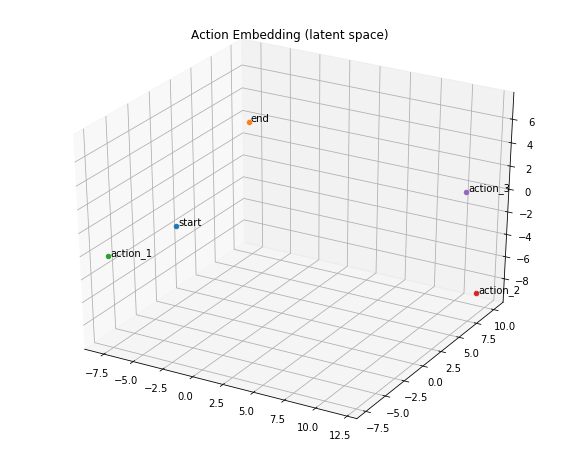

In [210]:
embeddings = model.embedding.weight.data.cpu().numpy()
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
for i in range(1, len(action2id)):
    ax.scatter(embeddings[i,0], embeddings[i,1], embeddings[i,2])
    ax.text(embeddings[i,0]+0.1, embeddings[i,1]+0.1, embeddings[i,2], s=id2action[i], fontsize=10)
    ax.grid(True)
ax.set_title('Action Embedding (latent space)')
plt.savefig('action_embeddings.png', dpi=500)

In [211]:
logfile['Embedded_Activities'] = logfile.SessionActivityInt.map(lambda x: embeddings[x].mean(axis=0))
logfile['Embedded_Activities_x'] = logfile.Embedded_Activities.map(lambda x: x[0])
logfile['Embedded_Activities_y'] = logfile.Embedded_Activities.map(lambda x: x[1])
logfile['Embedded_Activities_z'] = logfile.Embedded_Activities.map(lambda x: x[2])

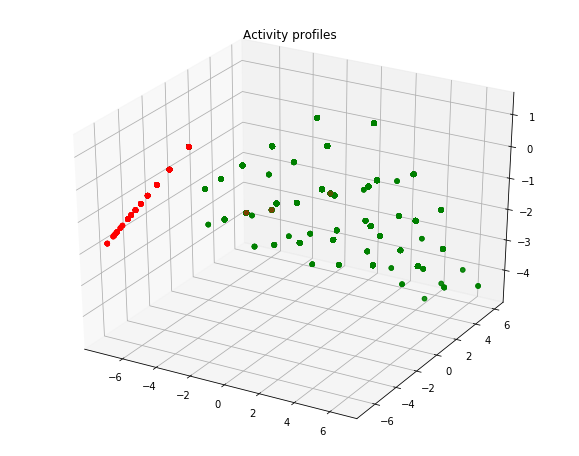

In [212]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Activity profiles')
for i in range(1, len(action2id)):
    ax.scatter(logfile.loc[logfile.FraudulentActivity==0, 'Embedded_Activities_x'], 
               logfile.loc[logfile.FraudulentActivity==0, 'Embedded_Activities_y'], 
               logfile.loc[logfile.FraudulentActivity==0, 'Embedded_Activities_z'], color='green')
    ax.scatter(logfile.loc[logfile.FraudulentActivity==1, 'Embedded_Activities_x'], 
               logfile.loc[logfile.FraudulentActivity==1, 'Embedded_Activities_y'], 
               logfile.loc[logfile.FraudulentActivity==1, 'Embedded_Activities_z'], color='red')
    
    ax.grid(True)
plt.savefig('activityprofiles.png', dpi=500)

In [213]:
user_profiles = logfile.groupby(['UserID', 'PotentialFraudster'], as_index=False).agg({
    'Embedded_Activities_x' : np.mean,
    'Embedded_Activities_y' : np.mean,
    'Embedded_Activities_z' : np.mean,
})

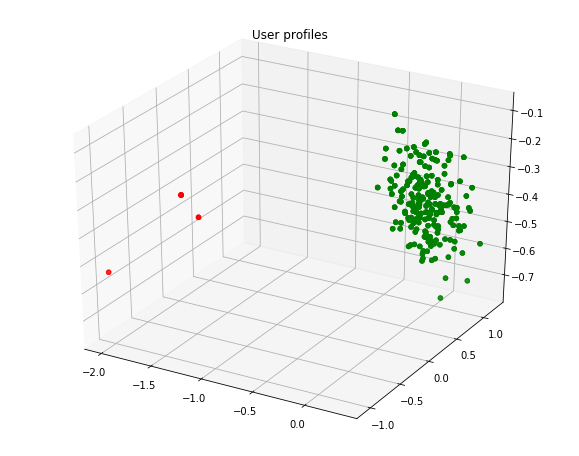

In [214]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('User profiles')
for i in range(1, len(action2id)):
    ax.scatter(user_profiles.loc[user_profiles.PotentialFraudster==0, 'Embedded_Activities_x'], 
               user_profiles.loc[user_profiles.PotentialFraudster==0, 'Embedded_Activities_y'], 
               user_profiles.loc[user_profiles.PotentialFraudster==0, 'Embedded_Activities_z'], color='green')
    ax.scatter(user_profiles.loc[user_profiles.PotentialFraudster==1, 'Embedded_Activities_x'], 
               user_profiles.loc[user_profiles.PotentialFraudster==1, 'Embedded_Activities_y'], 
               user_profiles.loc[user_profiles.PotentialFraudster==1, 'Embedded_Activities_z'], color='red')
    
    ax.grid(True)
plt.savefig('userprofiles.png', dpi=500)